# Bitcoin Price Prediction - Logistic Regression Baseline Model

Bu notebook, son 2 yılın Bitcoin verilerini kullanarak önümüzdeki 30 günün tahminini yapan bir Logistic Regression baseline modeli içerir.

## Özellikler:
- Recursive Feature Elimination (RFE) ile özellik seçimi
- Son 2 yılın verileri ile eğitim
- 30 günlük tahmin


In [1]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Kütüphaneler başarıyla yüklendi!")


Kütüphaneler başarıyla yüklendi!


## 1. Veri Toplama - Son 2 Yılın Bitcoin Verileri


In [2]:
# Son 2 yılın Bitcoin verilerini çekelim
end_date = datetime.now()
start_date = end_date - timedelta(days=730)  # 2 yıl = 730 gün

print(f"Veri çekme tarih aralığı: {start_date.date()} - {end_date.date()}")

# Bitcoin verilerini yfinance ile çekelim
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start=start_date, end=end_date)

print(f"\nToplam {len(btc_data)} günlük veri çekildi")
print(f"\nVeri şekli: {btc_data.shape}")
print("\nİlk 5 satır:")
print(btc_data.head())
print("\nSon 5 satır:")
print(btc_data.tail())


Veri çekme tarih aralığı: 2023-11-22 - 2025-11-21

Toplam 731 günlük veri çekildi

Veri şekli: (731, 7)

İlk 5 satır:
                                   Open          High           Low  \
Date                                                                  
2023-11-22 00:00:00+00:00  35756.554688  37856.980469  35670.972656   
2023-11-23 00:00:00+00:00  37420.433594  37643.917969  36923.863281   
2023-11-24 00:00:00+00:00  37296.316406  38415.339844  37261.605469   
2023-11-25 00:00:00+00:00  37721.414062  37892.429688  37617.417969   
2023-11-26 00:00:00+00:00  37796.828125  37820.300781  37162.750000   

                                  Close       Volume  Dividends  Stock Splits  
Date                                                                           
2023-11-22 00:00:00+00:00  37432.339844  24397247860        0.0           0.0  
2023-11-23 00:00:00+00:00  37289.621094  14214948217        0.0           0.0  
2023-11-24 00:00:00+00:00  37720.281250  22922957823        0.0 

## 2. Özellik Mühendisliği (Feature Engineering)


In [3]:
# Veriyi DataFrame'e dönüştürelim
df = btc_data.copy()

# Temel özellikler
df['Price'] = df['Close']
df['Volume'] = df['Volume']

# Teknik indikatörler oluşturalım
# 1. Moving Averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# 2. RSI (Relative Strength Index)
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# 3. MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# 4. Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
bb_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

# 5. Price Change Features
df['Price_Change'] = df['Close'].pct_change()
df['Price_Change_7'] = df['Close'].pct_change(periods=7)
df['Price_Change_14'] = df['Close'].pct_change(periods=14)
df['Price_Change_30'] = df['Close'].pct_change(periods=30)

# 6. Volatility
df['Volatility'] = df['Price_Change'].rolling(window=7).std()
df['Volatility_30'] = df['Price_Change'].rolling(window=30).std()

# 7. High-Low Features
df['HL_Ratio'] = df['High'] / df['Low']
df['OC_Ratio'] = df['Open'] / df['Close']

# 8. Volume Features
df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

# 9. Lag Features
for lag in [1, 2, 3, 5, 7]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

# NaN değerleri temizleyelim
df = df.dropna()

print(f"Özellik mühendisliği tamamlandı!")
print(f"Toplam özellik sayısı: {len(df.columns)}")
print(f"\nÖzellikler:")
print(df.columns.tolist())


Özellik mühendisliği tamamlandı!
Toplam özellik sayısı: 36

Özellikler:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Price', 'MA_7', 'MA_14', 'MA_30', 'MA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Price_Change', 'Price_Change_7', 'Price_Change_14', 'Price_Change_30', 'Volatility', 'Volatility_30', 'HL_Ratio', 'OC_Ratio', 'Volume_MA', 'Volume_Ratio', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_7']


In [4]:
# Hedef değişken: Bir sonraki gün fiyat artacak mı? (1: Artış, 0: Azalış/Düşüş)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Son satırı kaldıralım çünkü target değeri yok
df = df[:-1]

print(f"Hedef değişken oluşturuldu!")
print(f"\nHedef değişken dağılımı:")
print(df['Target'].value_counts())
print(f"\nArtış oranı: {df['Target'].mean():.2%}")


Hedef değişken oluşturuldu!

Hedef değişken dağılımı:
Target
1    348
0    333
Name: count, dtype: int64

Artış oranı: 51.10%


## 4. Özellik Seçimi - Recursive Feature Elimination (RFE)


In [5]:
# Model için kullanılacak özellikleri seçelim
feature_columns = [col for col in df.columns if col not in ['Target', 'Open', 'High', 'Low', 'Close', 'Price', 'Volume']]

X = df[feature_columns].copy()
y = df['Target'].copy()

print(f"Toplam özellik sayısı: {len(feature_columns)}")
print(f"\nÖzellikler: {feature_columns}")

# Eksik değerleri kontrol edelim
print(f"\nEksik değer sayısı: {X.isnull().sum().sum()}")


Toplam özellik sayısı: 30

Özellikler: ['Dividends', 'Stock Splits', 'MA_7', 'MA_14', 'MA_30', 'MA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'Price_Change', 'Price_Change_7', 'Price_Change_14', 'Price_Change_30', 'Volatility', 'Volatility_30', 'HL_Ratio', 'OC_Ratio', 'Volume_MA', 'Volume_Ratio', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_7']

Eksik değer sayısı: 0


In [6]:
# Veriyi train ve test setlerine ayıralım
# Son 30 günü test için ayırıyoruz (30 günlük tahmin için)
test_size = 30
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Veriyi normalize edelim
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame'e geri dönüştürelim
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Eğitim seti boyutu: (651, 30)
Test seti boyutu: (30, 30)


In [7]:
# RFE ile özellik seçimi
# Önce bir Logistic Regression modeli oluşturalım
lr_base = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')

# RFE ile en önemli 20 özelliği seçelim (sayıyı ihtiyaca göre ayarlayabilirsiniz)
n_features = min(20, len(feature_columns))
rfe = RFE(estimator=lr_base, n_features_to_select=n_features, step=1)
rfe.fit(X_train_scaled, y_train)

# Seçilen özellikler
selected_features = X_train_scaled.columns[rfe.support_].tolist()

print(f"Toplam özellik sayısı: {len(feature_columns)}")
print(f"RFE ile seçilen özellik sayısı: {len(selected_features)}")
print(f"\nSeçilen özellikler:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Özellik önem sıralaması
feature_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Rank')

print(f"\nÖzellik sıralaması (ilk 10):")
print(feature_ranking.head(10))


Toplam özellik sayısı: 30
RFE ile seçilen özellik sayısı: 20

Seçilen özellikler:
1. MA_14
2. MA_30
3. RSI
4. MACD
5. MACD_Signal
6. MACD_Hist
7. BB_Upper
8. BB_Width
9. BB_Position
10. Price_Change
11. Price_Change_7
12. Price_Change_14
13. Price_Change_30
14. Volatility
15. OC_Ratio
16. Volume_MA
17. Close_Lag_1
18. Close_Lag_3
19. Close_Lag_5
20. Close_Lag_7

Özellik sıralaması (ilk 10):
            Feature  Rank  Selected
14      BB_Position     1      True
27      Close_Lag_3     1      True
25      Close_Lag_1     1      True
23        Volume_MA     1      True
22         OC_Ratio     1      True
19       Volatility     1      True
18  Price_Change_30     1      True
17  Price_Change_14     1      True
16   Price_Change_7     1      True
15     Price_Change     1      True


## 5. Logistic Regression Modeli Eğitimi


In [8]:
# Seçilen özelliklerle modeli eğitelim
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# Logistic Regression modeli
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', class_weight='balanced')
lr_model.fit(X_train_selected, y_train)

# Eğitim ve test tahminleri
y_train_pred = lr_model.predict(X_train_selected)
y_test_pred = lr_model.predict(X_test_selected)

# Olasılık tahminleri
y_train_proba = lr_model.predict_proba(X_train_selected)[:, 1]
y_test_proba = lr_model.predict_proba(X_test_selected)[:, 1]

print("Model eğitimi tamamlandı!")
print(f"\nEğitim seti doğruluğu: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test seti doğruluğu: {accuracy_score(y_test, y_test_pred):.4f}")

print("\n=== Test Seti Sınıflandırma Raporu ===")
print(classification_report(y_test, y_test_pred, target_names=['Düşüş', 'Artış']))


Model eğitimi tamamlandı!

Eğitim seti doğruluğu: 0.5545
Test seti doğruluğu: 0.5667

=== Test Seti Sınıflandırma Raporu ===
              precision    recall  f1-score   support

       Düşüş       0.67      0.47      0.55        17
       Artış       0.50      0.69      0.58        13

    accuracy                           0.57        30
   macro avg       0.58      0.58      0.57        30
weighted avg       0.59      0.57      0.56        30



## 6. Model Performans Görselleştirme


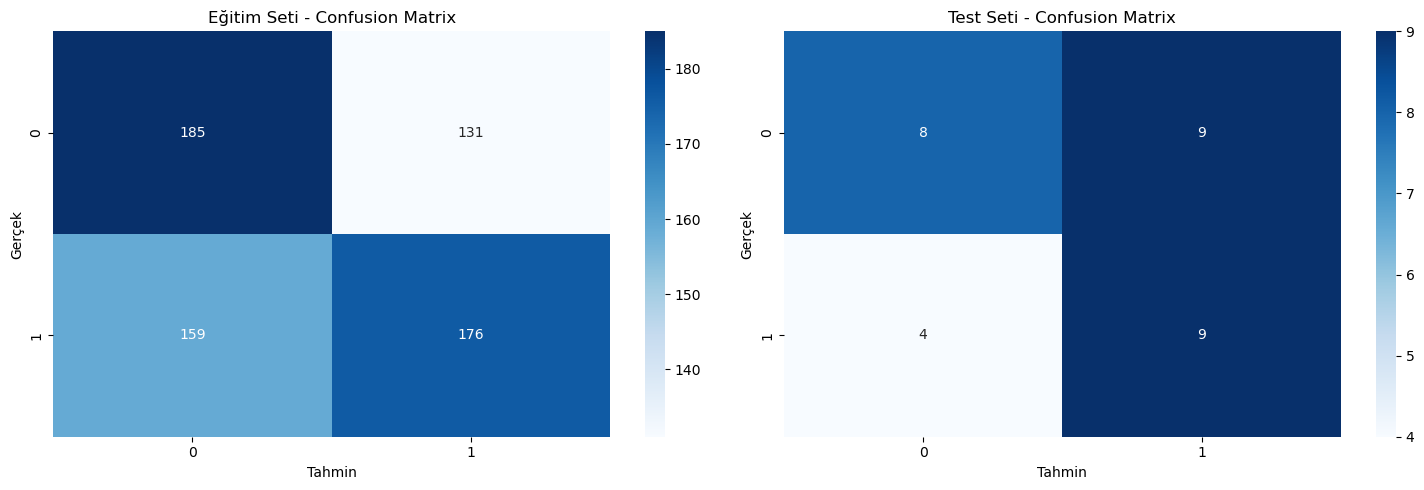

In [9]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Eğitim seti confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Eğitim Seti - Confusion Matrix')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

# Test seti confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Seti - Confusion Matrix')
axes[1].set_ylabel('Gerçek')
axes[1].set_xlabel('Tahmin')

plt.tight_layout()
plt.show()


## 7. Önümüzdeki 30 Günün Tahmini


In [10]:
# 30 günlük tahmin için fonksiyon
def predict_next_30_days(model, scaler, df, feature_columns, selected_features, n_days=30):
    """
    Önümüzdeki n_days günün tahminini yapar
    """
    predictions = []
    probabilities = []
    current_data = df.copy()
    
    # Son verileri al
    last_features = current_data[feature_columns].iloc[-1:].copy()
    
    for day in range(n_days):
        # Veriyi normalize et
        last_features_scaled = scaler.transform(last_features)
        last_features_scaled = pd.DataFrame(last_features_scaled, columns=last_features.columns)
        
        # Tahmin yap
        X_pred = last_features_scaled[selected_features]
        pred = model.predict(X_pred)[0]
        proba = model.predict_proba(X_pred)[0, 1]
        
        predictions.append(pred)
        probabilities.append(proba)
        
        # Bir sonraki gün için veriyi güncelle (basit bir yaklaşım)
        # Gerçek uygulamada, gelecekteki fiyatları tahmin etmek için daha karmaşık bir yaklaşım gerekir
        # Burada sadece son değerleri kullanıyoruz (baseline için)
        last_features = current_data[feature_columns].iloc[-1:].copy()
    
    return predictions, probabilities

# Tahminleri yapalım
future_predictions, future_probabilities = predict_next_30_days(
    lr_model, scaler, df, feature_columns, selected_features, n_days=30
)

print("30 günlük tahmin tamamlandı!")
print(f"\nTahminler (1=Artış, 0=Düşüş):")
for i, (pred, prob) in enumerate(zip(future_predictions, future_probabilities), 1):
    direction = "Artış" if pred == 1 else "Düşüş"
    print(f"Gün {i}: {direction} (Olasılık: {prob:.2%})")

# Artış tahminlerinin sayısı
increase_count = sum(future_predictions)
decrease_count = 30 - increase_count

print(f"\nÖzet:")
print(f"Artış tahmini: {increase_count} gün ({increase_count/30:.1%})")
print(f"Düşüş tahmini: {decrease_count} gün ({decrease_count/30:.1%})")


30 günlük tahmin tamamlandı!

Tahminler (1=Artış, 0=Düşüş):
Gün 1: Artış (Olasılık: 82.04%)
Gün 2: Artış (Olasılık: 82.04%)
Gün 3: Artış (Olasılık: 82.04%)
Gün 4: Artış (Olasılık: 82.04%)
Gün 5: Artış (Olasılık: 82.04%)
Gün 6: Artış (Olasılık: 82.04%)
Gün 7: Artış (Olasılık: 82.04%)
Gün 8: Artış (Olasılık: 82.04%)
Gün 9: Artış (Olasılık: 82.04%)
Gün 10: Artış (Olasılık: 82.04%)
Gün 11: Artış (Olasılık: 82.04%)
Gün 12: Artış (Olasılık: 82.04%)
Gün 13: Artış (Olasılık: 82.04%)
Gün 14: Artış (Olasılık: 82.04%)
Gün 15: Artış (Olasılık: 82.04%)
Gün 16: Artış (Olasılık: 82.04%)
Gün 17: Artış (Olasılık: 82.04%)
Gün 18: Artış (Olasılık: 82.04%)
Gün 19: Artış (Olasılık: 82.04%)
Gün 20: Artış (Olasılık: 82.04%)
Gün 21: Artış (Olasılık: 82.04%)
Gün 22: Artış (Olasılık: 82.04%)
Gün 23: Artış (Olasılık: 82.04%)
Gün 24: Artış (Olasılık: 82.04%)
Gün 25: Artış (Olasılık: 82.04%)
Gün 26: Artış (Olasılık: 82.04%)
Gün 27: Artış (Olasılık: 82.04%)
Gün 28: Artış (Olasılık: 82.04%)
Gün 29: Artış (Olasılık: 

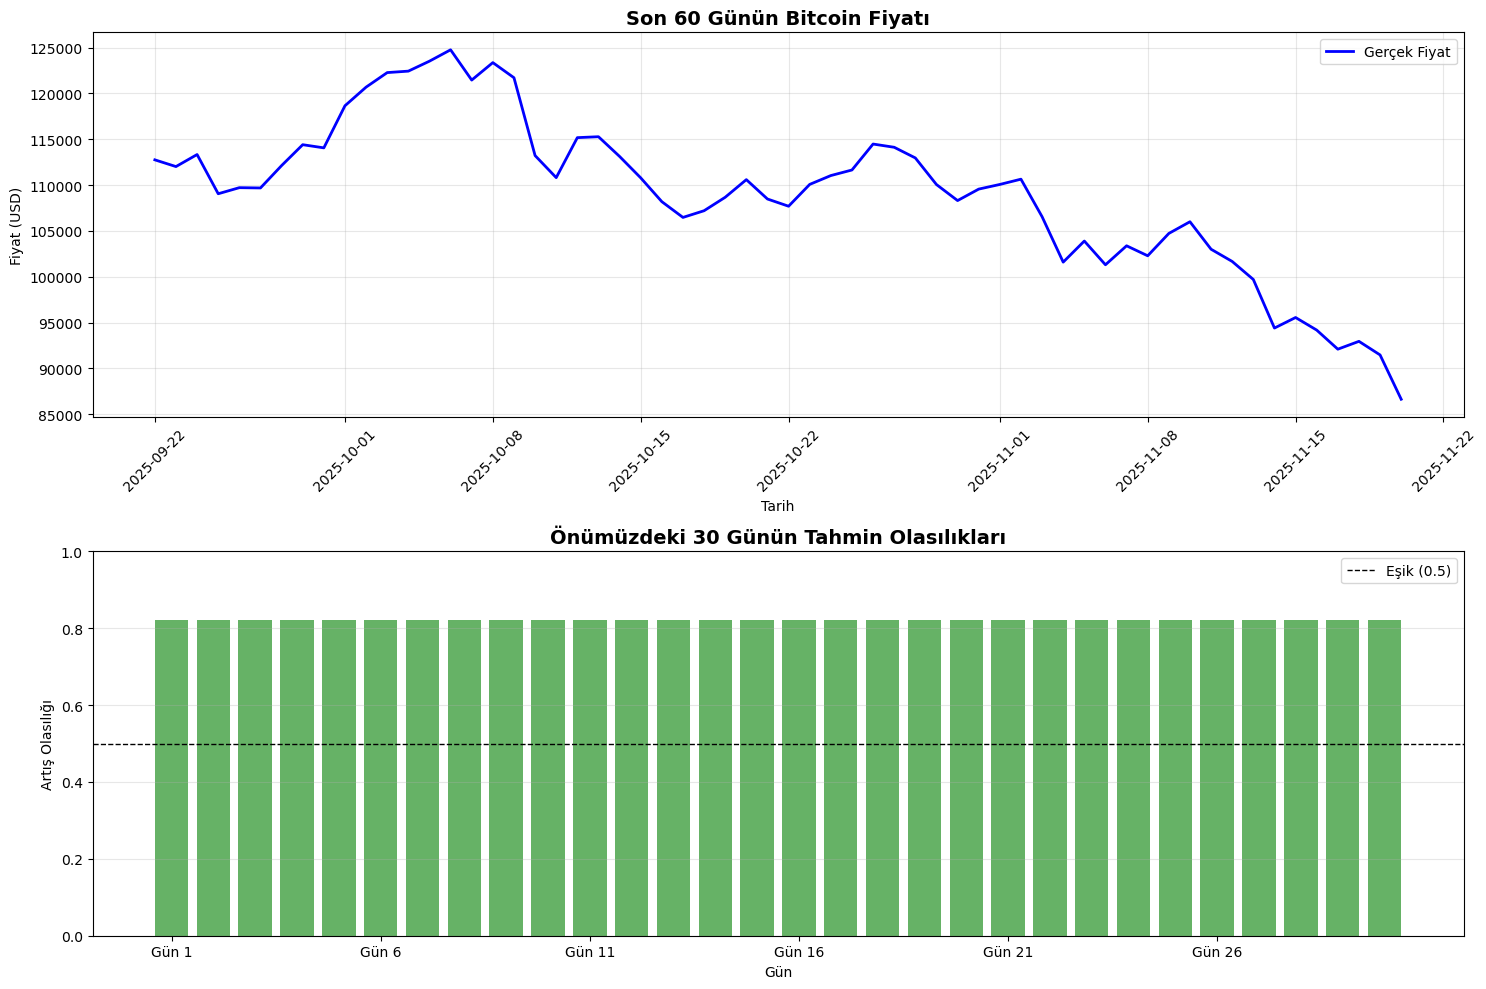


=== 30 Günlük Tahmin Özeti ===
 Gün Tahmin Artış Olasılığı
   1  Artış          82.04%
   2  Artış          82.04%
   3  Artış          82.04%
   4  Artış          82.04%
   5  Artış          82.04%
   6  Artış          82.04%
   7  Artış          82.04%
   8  Artış          82.04%
   9  Artış          82.04%
  10  Artış          82.04%
  11  Artış          82.04%
  12  Artış          82.04%
  13  Artış          82.04%
  14  Artış          82.04%
  15  Artış          82.04%
  16  Artış          82.04%
  17  Artış          82.04%
  18  Artış          82.04%
  19  Artış          82.04%
  20  Artış          82.04%
  21  Artış          82.04%
  22  Artış          82.04%
  23  Artış          82.04%
  24  Artış          82.04%
  25  Artış          82.04%
  26  Artış          82.04%
  27  Artış          82.04%
  28  Artış          82.04%
  29  Artış          82.04%
  30  Artış          82.04%


In [11]:
# Tahminleri görselleştirelim
try:
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Son 60 günün gerçek fiyatları
    last_60_days = df['Close'].tail(60)
    
    axes[0].plot(last_60_days.index, last_60_days.values, label='Gerçek Fiyat', linewidth=2, color='blue')
    axes[0].set_title('Son 60 Günün Bitcoin Fiyatı', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tarih')
    axes[0].set_ylabel('Fiyat (USD)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # 30 günlük tahmin görselleştirmesi
    future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30, freq='D')
    
    # Artış/Düşüş tahminlerini göster
    colors = ['red' if p == 0 else 'green' for p in future_predictions]
    axes[1].bar(range(30), future_probabilities, color=colors, alpha=0.6)
    axes[1].axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Eşik (0.5)')
    axes[1].set_title('Önümüzdeki 30 Günün Tahmin Olasılıkları', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Gün')
    axes[1].set_ylabel('Artış Olasılığı')
    axes[1].set_xticks(range(0, 30, 5))
    axes[1].set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Tahmin özeti DataFrame'i
    prediction_summary = pd.DataFrame({
        'Gün': range(1, 31),
        'Tahmin': ['Artış' if p == 1 else 'Düşüş' for p in future_predictions],
        'Artış Olasılığı': [f"{prob:.2%}" for prob in future_probabilities]
    })

    print("\n=== 30 Günlük Tahmin Özeti ===")
    print(prediction_summary.to_string(index=False))
    
except Exception as e:
    print(f"Görselleştirme hatası: {e}")
    print(f"future_predictions tipi: {type(future_predictions)}")
    print(f"future_probabilities tipi: {type(future_probabilities)}")
    if 'future_predictions' in locals():
        print(f"future_predictions uzunluğu: {len(future_predictions)}")
    if 'future_probabilities' in locals():
        print(f"future_probabilities uzunluğu: {len(future_probabilities)}")


## 8. Model Özeti ve Sonuçlar


In [12]:
print("=" * 60)
print("LOGISTIC REGRESSION BASELINE MODEL ÖZETİ")
print("=" * 60)

print(f"\n1. VERİ:")
print(f"   - Eğitim verisi: {len(X_train)} gün")
print(f"   - Test verisi: {len(X_test)} gün")
print(f"   - Toplam özellik sayısı: {len(feature_columns)}")
print(f"   - RFE ile seçilen özellik sayısı: {len(selected_features)}")

print(f"\n2. MODEL PERFORMANSI:")
print(f"   - Eğitim doğruluğu: {accuracy_score(y_train, y_train_pred):.2%}")
print(f"   - Test doğruluğu: {accuracy_score(y_test, y_test_pred):.2%}")

print(f"\n3. 30 GÜNLÜK TAHMİN:")
print(f"   - Artış tahmini: {sum(future_predictions)} gün ({sum(future_predictions)/30:.1%})")
print(f"   - Düşüş tahmini: {30-sum(future_predictions)} gün ({(30-sum(future_predictions))/30:.1%})")
print(f"   - Ortalama artış olasılığı: {np.mean(future_probabilities):.2%}")

print(f"\n4. SEÇİLEN ÖZELLİKLER:")
for i, feature in enumerate(selected_features, 1):
    print(f"   {i}. {feature}")

print("\n" + "=" * 60)
print("NOT: Bu bir baseline modeldir. Daha iyi sonuçlar için:")
print("- Daha fazla özellik mühendisliği")
print("- Farklı algoritmalar (Random Forest, XGBoost, LSTM vb.)")
print("- Hyperparameter tuning")
print("- Ensemble yöntemleri")
print("kullanılabilir.")
print("=" * 60)


LOGISTIC REGRESSION BASELINE MODEL ÖZETİ

1. VERİ:
   - Eğitim verisi: 651 gün
   - Test verisi: 30 gün
   - Toplam özellik sayısı: 30
   - RFE ile seçilen özellik sayısı: 20

2. MODEL PERFORMANSI:
   - Eğitim doğruluğu: 55.45%
   - Test doğruluğu: 56.67%

3. 30 GÜNLÜK TAHMİN:
   - Artış tahmini: 30 gün (100.0%)
   - Düşüş tahmini: 0 gün (0.0%)
   - Ortalama artış olasılığı: 82.04%

4. SEÇİLEN ÖZELLİKLER:
   1. MA_14
   2. MA_30
   3. RSI
   4. MACD
   5. MACD_Signal
   6. MACD_Hist
   7. BB_Upper
   8. BB_Width
   9. BB_Position
   10. Price_Change
   11. Price_Change_7
   12. Price_Change_14
   13. Price_Change_30
   14. Volatility
   15. OC_Ratio
   16. Volume_MA
   17. Close_Lag_1
   18. Close_Lag_3
   19. Close_Lag_5
   20. Close_Lag_7

NOT: Bu bir baseline modeldir. Daha iyi sonuçlar için:
- Daha fazla özellik mühendisliği
- Farklı algoritmalar (Random Forest, XGBoost, LSTM vb.)
- Hyperparameter tuning
- Ensemble yöntemleri
kullanılabilir.


## 9. Özellik Önem Analizi


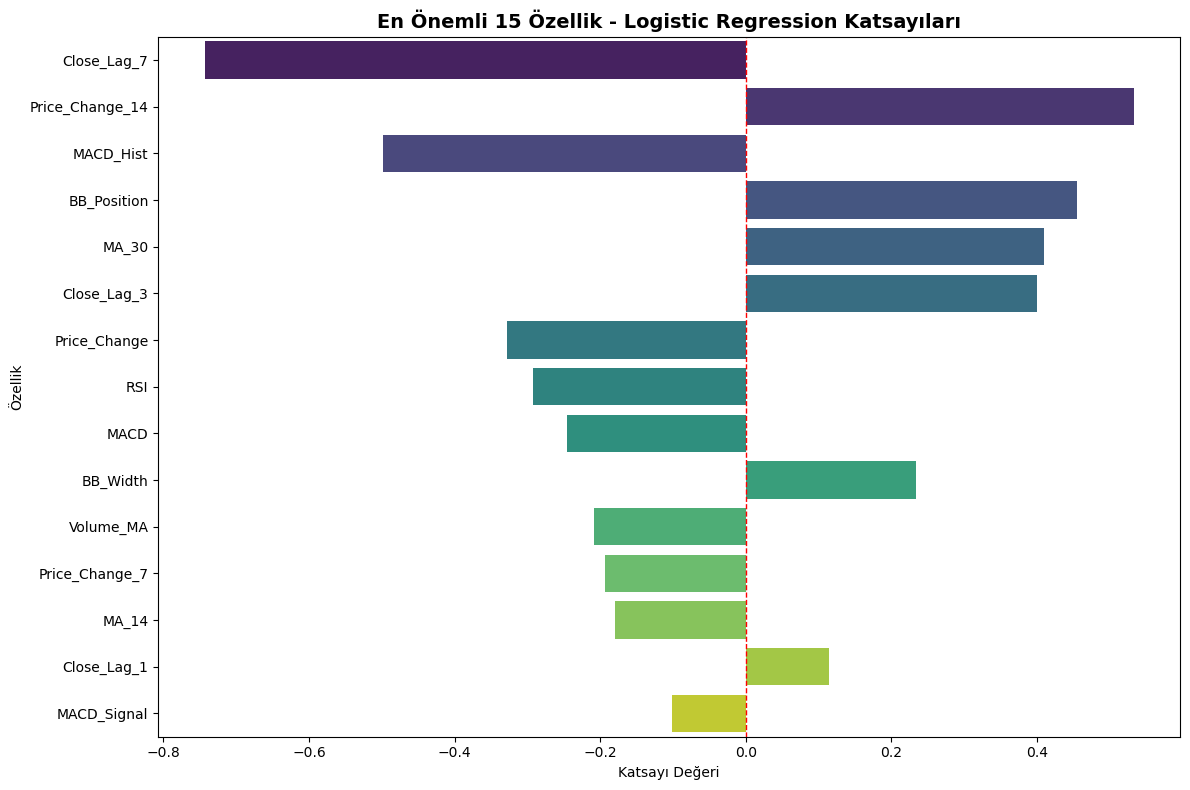

En önemli 10 özellik:
        Feature  Coefficient
    Close_Lag_7    -0.743230
Price_Change_14     0.532503
      MACD_Hist    -0.498695
    BB_Position     0.454409
          MA_30     0.409026
    Close_Lag_3     0.399768
   Price_Change    -0.328364
            RSI    -0.291812
           MACD    -0.245659
       BB_Width     0.233143


In [13]:
# Model katsayılarını alarak özellik önemini görselleştirelim
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), y='Feature', x='Coefficient', palette='viridis')
plt.title('En Önemli 15 Özellik - Logistic Regression Katsayıları', fontsize=14, fontweight='bold')
plt.xlabel('Katsayı Değeri')
plt.ylabel('Özellik')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("En önemli 10 özellik:")
print(feature_importance.head(10)[['Feature', 'Coefficient']].to_string(index=False))


## 10. Gelecek 30 Günlük Detaylı Analiz


In [14]:
# Gelecek 30 gün için detaylı analiz fonksiyonu
def detailed_30_day_analysis(model, scaler, df, feature_columns, selected_features, n_days=30):
    """
    Gelecek 30 gün için detaylı analiz yapar
    """
    current_price = df['Close'].iloc[-1]
    predictions = []
    probabilities = []
    price_scenarios = []
    
    # Son verileri al
    last_features = df[feature_columns].iloc[-1:].copy()
    
    # Geçmiş volatiliteyi hesapla
    historical_volatility = df['Price_Change'].tail(30).std()
    historical_mean_change = df['Price_Change'].tail(30).mean()
    
    for day in range(n_days):
        # Veriyi normalize et
        last_features_scaled = scaler.transform(last_features)
        last_features_scaled = pd.DataFrame(last_features_scaled, columns=last_features.columns)
        
        # Tahmin yap
        X_pred = last_features_scaled[selected_features]
        pred = model.predict(X_pred)[0]
        proba = model.predict_proba(X_pred)[0, 1]
        
        predictions.append(pred)
        probabilities.append(proba)
        
        # Fiyat senaryoları oluştur (olasılık bazlı)
        # Artış olasılığına göre beklenen değişim yüzdesi
        if proba > 0.5:
            # Artış senaryosu
            expected_change = historical_mean_change + (proba - 0.5) * historical_volatility * 2
        else:
            # Düşüş senaryosu
            expected_change = historical_mean_change - (0.5 - proba) * historical_volatility * 2
        
        # Senaryo fiyatları
        optimistic_price = current_price * (1 + expected_change + historical_volatility)
        base_price = current_price * (1 + expected_change)
        pessimistic_price = current_price * (1 + expected_change - historical_volatility)
        
        price_scenarios.append({
            'day': day + 1,
            'prediction': pred,
            'probability': proba,
            'base_price': base_price,
            'optimistic_price': optimistic_price,
            'pessimistic_price': pessimistic_price,
            'expected_change_pct': expected_change * 100
        })
        
        # Bir sonraki iterasyon için güncelle (basit yaklaşım)
        current_price = base_price
        last_features = df[feature_columns].iloc[-1:].copy()
    
    return predictions, probabilities, price_scenarios

# Detaylı analizi yapalım
future_predictions_detailed, future_probabilities_detailed, price_scenarios = detailed_30_day_analysis(
    lr_model, scaler, df, feature_columns, selected_features, n_days=30
)

print("30 günlük detaylı analiz tamamlandı!")


30 günlük detaylı analiz tamamlandı!


In [15]:
# Analiz sonuçlarını DataFrame'e dönüştürelim
current_price = df['Close'].iloc[-1]
analysis_df = pd.DataFrame(price_scenarios)

# Kümülatif değişim hesapla (mevcut fiyata göre yüzde değişim)
analysis_df['cumulative_change_pct'] = ((analysis_df['base_price'] - current_price) / current_price * 100)

print("=" * 80)
print("GELECEK 30 GÜNLÜK DETAYLI ANALİZ RAPORU")
print("=" * 80)
print(f"\nMevcut Bitcoin Fiyatı: ${current_price:,.2f}")
print(f"Analiz Tarihi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n{'='*80}")
print("GÜNLÜK TAHMİN ÖZETİ")
print(f"{'='*80}")
print(f"{'Gün':<6} {'Tahmin':<10} {'Olasılık':<12} {'Beklenen Fiyat':<18} {'Değişim %':<12}")
print("-" * 80)

for idx, row in analysis_df.iterrows():
    direction = "Artış" if row['prediction'] == 1 else "Düşüş"
    print(f"{int(row['day']):<6} {direction:<10} {row['probability']:.2%} {'$' + str(int(row['base_price'])):<18} {row['expected_change_pct']:>10.2f}%")

print(f"\n{'='*80}")
print("GENEL İSTATİSTİKLER")
print(f"{'='*80}")

increase_days = sum(future_predictions_detailed)
decrease_days = 30 - increase_days
avg_probability = np.mean(future_probabilities_detailed)

final_price = analysis_df['base_price'].iloc[-1]
total_change = ((final_price - current_price) / current_price) * 100

print(f"Artış tahmini: {increase_days} gün ({increase_days/30:.1%})")
print(f"Düşüş tahmini: {decrease_days} gün ({decrease_days/30:.1%})")
print(f"Ortalama artış olasılığı: {avg_probability:.2%}")
print(f"\n30 gün sonra beklenen fiyat: ${final_price:,.2f}")
print(f"Toplam beklenen değişim: {total_change:+.2f}%")
print(f"Beklenen fiyat aralığı: ${analysis_df['pessimistic_price'].min():,.2f} - ${analysis_df['optimistic_price'].max():,.2f}")


GELECEK 30 GÜNLÜK DETAYLI ANALİZ RAPORU

Mevcut Bitcoin Fiyatı: $86,631.90
Analiz Tarihi: 2025-11-21 15:23:54

GÜNLÜK TAHMİN ÖZETİ
Gün    Tahmin     Olasılık     Beklenen Fiyat     Değişim %   
--------------------------------------------------------------------------------
1      Artış      82.04% $87269                   0.74%
2      Artış      82.04% $87911                   0.74%
3      Artış      82.04% $88557                   0.74%
4      Artış      82.04% $89209                   0.74%
5      Artış      82.04% $89865                   0.74%
6      Artış      82.04% $90526                   0.74%
7      Artış      82.04% $91192                   0.74%
8      Artış      82.04% $91863                   0.74%
9      Artış      82.04% $92539                   0.74%
10     Artış      82.04% $93219                   0.74%
11     Artış      82.04% $93905                   0.74%
12     Artış      82.04% $94596                   0.74%
13     Artış      82.04% $95292                   0.7

In [16]:
# Risk Analizi
print(f"\n{'='*80}")
print("RİSK ANALİZİ")
print(f"{'='*80}")

# Volatilite analizi
price_volatility = analysis_df['base_price'].std()
max_drawdown = ((analysis_df['base_price'] - analysis_df['base_price'].cummax()) / analysis_df['base_price'].cummax() * 100).min()
max_gain = ((analysis_df['base_price'] - analysis_df['base_price'].cummin()) / analysis_df['base_price'].cummin() * 100).max()

# Güven seviyeleri
confidence_95_lower = analysis_df['pessimistic_price'].quantile(0.025)
confidence_95_upper = analysis_df['optimistic_price'].quantile(0.975)
confidence_68_lower = analysis_df['pessimistic_price'].quantile(0.16)
confidence_68_upper = analysis_df['optimistic_price'].quantile(0.84)

print(f"Fiyat volatilitesi: ${price_volatility:,.2f}")
print(f"Maksimum düşüş (Drawdown): {max_drawdown:.2f}%")
print(f"Maksimum kazanç: {max_gain:.2f}%")
print(f"\nGüven Aralıkları (30 gün sonra):")
print(f"  68% güven aralığı: ${confidence_68_lower:,.2f} - ${confidence_68_upper:,.2f}")
print(f"  95% güven aralığı: ${confidence_95_lower:,.2f} - ${confidence_95_upper:,.2f}")

# Risk skoru (0-100, yüksek = riskli)
risk_score = min(100, abs(max_drawdown) * 2 + price_volatility / current_price * 1000)
print(f"\nRisk Skoru: {risk_score:.1f}/100")
if risk_score < 30:
    risk_level = "Düşük"
elif risk_score < 60:
    risk_level = "Orta"
else:
    risk_level = "Yüksek"
print(f"Risk Seviyesi: {risk_level}")



RİSK ANALİZİ
Fiyat volatilitesi: $6,272.32
Maksimum düşüş (Drawdown): 0.00%
Maksimum kazanç: 23.68%

Güven Aralıkları (30 gün sonra):
  68% güven aralığı: $88,250.39 - $106,683.85
  95% güven aralığı: $85,754.02 - $109,789.32

Risk Skoru: 72.4/100
Risk Seviyesi: Yüksek


In [17]:
# Trend Analizi
print(f"\n{'='*80}")
print("TREND ANALİZİ")
print(f"{'='*80}")

# Haftalık trendler
week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
week2_avg = analysis_df[(analysis_df['day'] > 7) & (analysis_df['day'] <= 14)]['base_price'].mean()
week3_avg = analysis_df[(analysis_df['day'] > 14) & (analysis_df['day'] <= 21)]['base_price'].mean()
week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()

print(f"1. Hafta ortalama beklenen fiyat: ${week1_avg:,.2f}")
print(f"2. Hafta ortalama beklenen fiyat: ${week2_avg:,.2f}")
print(f"3. Hafta ortalama beklenen fiyat: ${week3_avg:,.2f}")
print(f"4. Hafta ortalama beklenen fiyat: ${week4_avg:,.2f}")

# Trend yönü
if week4_avg > week1_avg:
    trend_direction = "Yükseliş"
    trend_strength = ((week4_avg - week1_avg) / week1_avg) * 100
else:
    trend_direction = "Düşüş"
    trend_strength = ((week1_avg - week4_avg) / week1_avg) * 100

print(f"\nGenel Trend: {trend_direction}")
print(f"Trend Gücü: {trend_strength:.2f}%")

# En yüksek ve en düşük beklenen fiyatlar
max_price_day = analysis_df.loc[analysis_df['base_price'].idxmax(), 'day']
min_price_day = analysis_df.loc[analysis_df['base_price'].idxmin(), 'day']
max_price = analysis_df['base_price'].max()
min_price = analysis_df['base_price'].min()

print(f"\nEn yüksek beklenen fiyat: ${max_price:,.2f} (Gün {int(max_price_day)})")
print(f"En düşük beklenen fiyat: ${min_price:,.2f} (Gün {int(min_price_day)})")



TREND ANALİZİ
1. Hafta ortalama beklenen fiyat: $89,218.89
2. Hafta ortalama beklenen fiyat: $93,915.75
3. Hafta ortalama beklenen fiyat: $98,859.87
4. Hafta ortalama beklenen fiyat: $104,837.30

Genel Trend: Yükseliş
Trend Gücü: 17.51%

En yüksek beklenen fiyat: $107,937.01 (Gün 30)
En düşük beklenen fiyat: $87,269.18 (Gün 1)


## 11. Görselleştirmeler - Detaylı Analiz


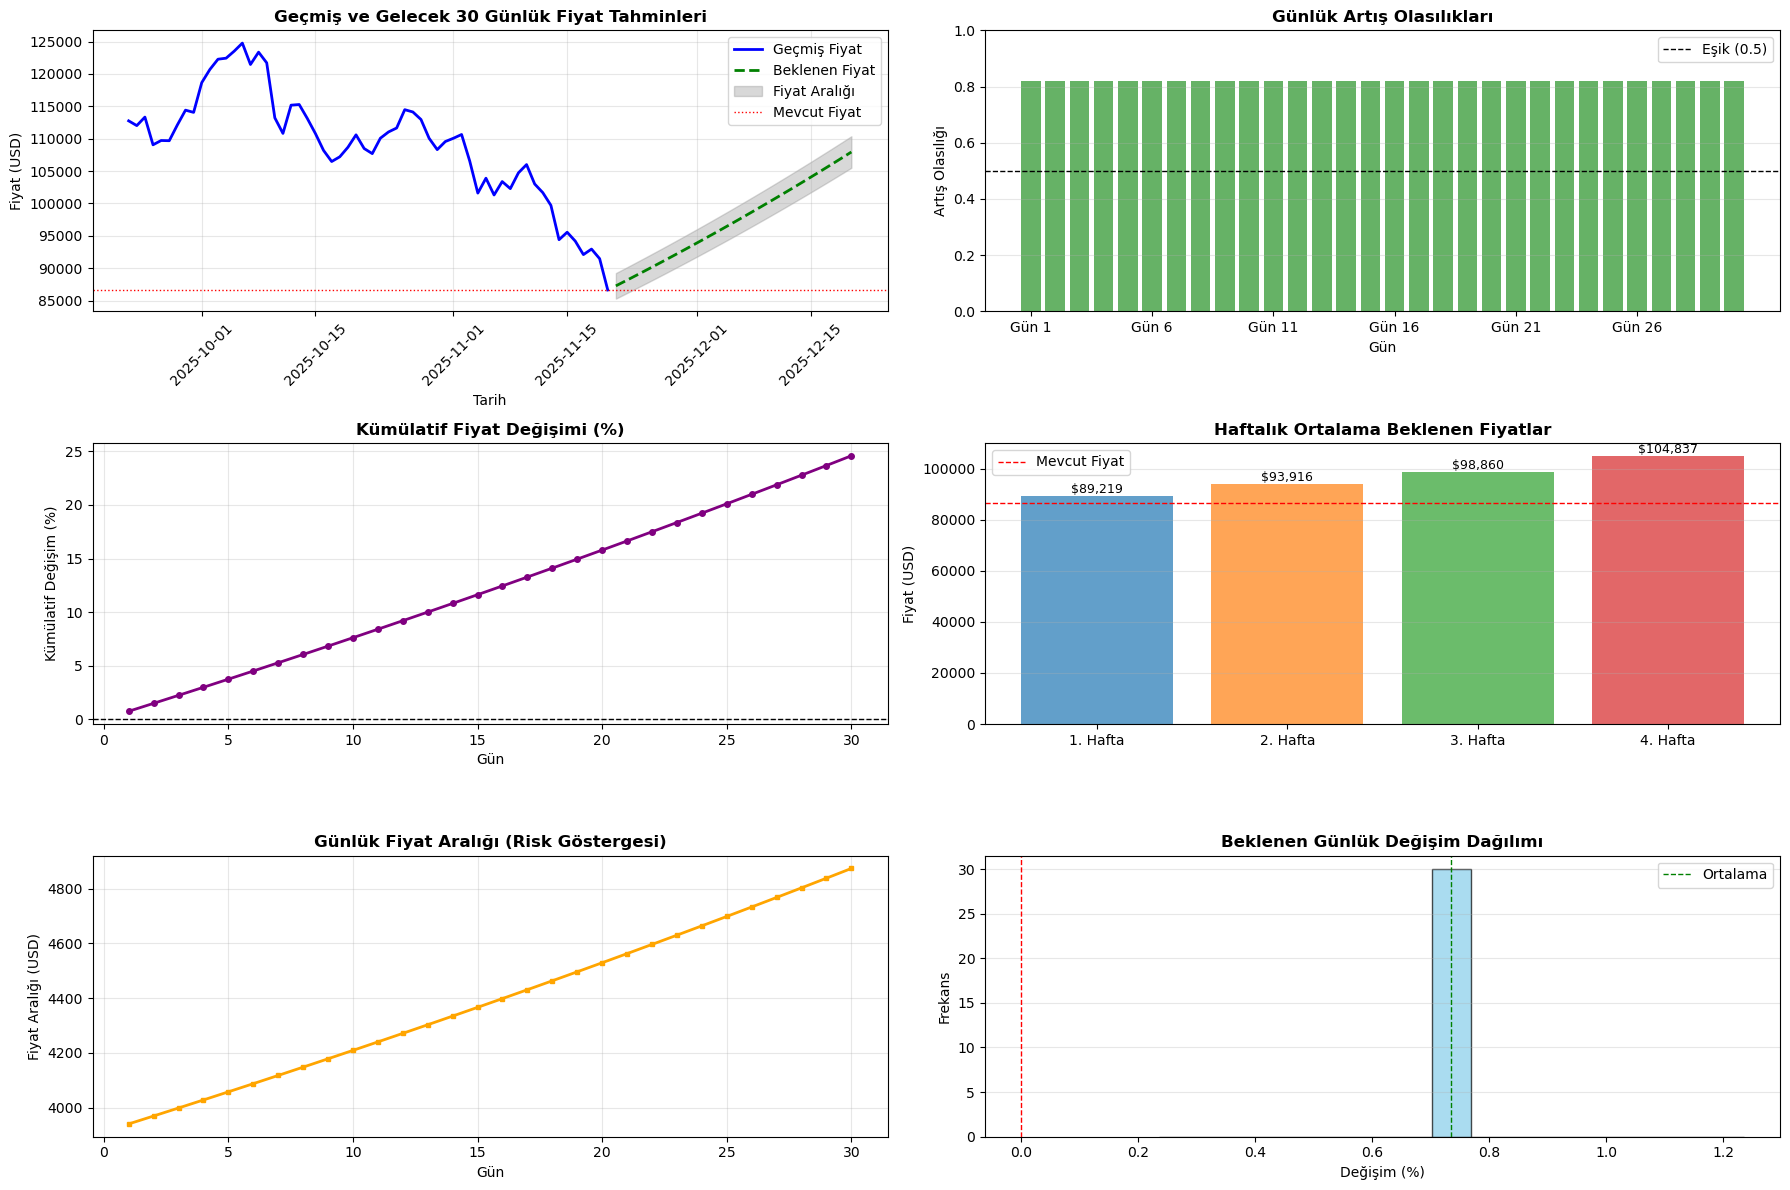

In [18]:
# Detaylı görselleştirmeler
try:
    # Gerekli değişkenlerin tanımlı olup olmadığını kontrol et ve hesapla
    try:
        current_price
    except NameError:
        current_price = df['Close'].iloc[-1]
    
    try:
        analysis_df
    except NameError:
        print("Hata: analysis_df bulunamadı. Lütfen önce Cell 24 ve 25'i çalıştırın.")
        raise
    
    try:
        future_predictions_detailed
    except NameError:
        print("Hata: future_predictions_detailed bulunamadı. Lütfen önce Cell 24'ü çalıştırın.")
        raise
    
    try:
        future_probabilities_detailed
    except NameError:
        print("Hata: future_probabilities_detailed bulunamadı. Lütfen önce Cell 24'ü çalıştırın.")
        raise
    
    # Haftalık ortalamaları hesapla (eğer tanımlı değilse)
    try:
        week1_avg
        week2_avg
        week3_avg
        week4_avg
    except NameError:
        week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
        week2_avg = analysis_df[(analysis_df['day'] > 7) & (analysis_df['day'] <= 14)]['base_price'].mean()
        week3_avg = analysis_df[(analysis_df['day'] > 14) & (analysis_df['day'] <= 21)]['base_price'].mean()
        week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()
    
    fig = plt.figure(figsize=(18, 12))

    # 1. Fiyat Tahminleri ve Senaryolar
    ax1 = plt.subplot(3, 2, 1)
    last_60_days = df['Close'].tail(60)
    ax1.plot(last_60_days.index, last_60_days.values, label='Geçmiş Fiyat', linewidth=2, color='blue')

    future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30, freq='D')
    ax1.plot(future_dates, analysis_df['base_price'].values, label='Beklenen Fiyat', linewidth=2, color='green', linestyle='--')
    ax1.fill_between(future_dates, analysis_df['pessimistic_price'], analysis_df['optimistic_price'], 
                     alpha=0.3, color='gray', label='Fiyat Aralığı')
    ax1.axhline(y=current_price, color='red', linestyle=':', linewidth=1, label='Mevcut Fiyat')
    ax1.set_title('Geçmiş ve Gelecek 30 Günlük Fiyat Tahminleri', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Tarih')
    ax1.set_ylabel('Fiyat (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # 2. Günlük Değişim Olasılıkları
    ax2 = plt.subplot(3, 2, 2)
    colors = ['red' if p == 0 else 'green' for p in future_predictions_detailed]
    bars = ax2.bar(range(30), future_probabilities_detailed, color=colors, alpha=0.6)
    ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Eşik (0.5)')
    ax2.set_title('Günlük Artış Olasılıkları', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Gün')
    ax2.set_ylabel('Artış Olasılığı')
    ax2.set_xticks(range(0, 30, 5))
    ax2.set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim([0, 1])

    # 3. Kümülatif Değişim
    ax3 = plt.subplot(3, 2, 3)
    ax3.plot(range(1, 31), analysis_df['cumulative_change_pct'], linewidth=2, color='purple', marker='o', markersize=4)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax3.set_title('Kümülatif Fiyat Değişimi (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Gün')
    ax3.set_ylabel('Kümülatif Değişim (%)')
    ax3.grid(True, alpha=0.3)

    # 4. Haftalık Trend Karşılaştırması
    ax4 = plt.subplot(3, 2, 4)
    weeks = ['1. Hafta', '2. Hafta', '3. Hafta', '4. Hafta']
    week_prices = [week1_avg, week2_avg, week3_avg, week4_avg]
    bars = ax4.bar(weeks, week_prices, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    ax4.axhline(y=current_price, color='red', linestyle='--', linewidth=1, label='Mevcut Fiyat')
    ax4.set_title('Haftalık Ortalama Beklenen Fiyatlar', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Fiyat (USD)')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    for i, (bar, price) in enumerate(zip(bars, week_prices)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'${price:,.0f}', ha='center', va='bottom', fontsize=9)

    # 5. Risk Dağılımı
    ax5 = plt.subplot(3, 2, 5)
    price_ranges = analysis_df['optimistic_price'] - analysis_df['pessimistic_price']
    ax5.plot(range(1, 31), price_ranges, linewidth=2, color='orange', marker='s', markersize=3)
    ax5.set_title('Günlük Fiyat Aralığı (Risk Göstergesi)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Gün')
    ax5.set_ylabel('Fiyat Aralığı (USD)')
    ax5.grid(True, alpha=0.3)

    # 6. Beklenen Değişim Dağılımı
    ax6 = plt.subplot(3, 2, 6)
    ax6.hist(analysis_df['expected_change_pct'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    ax6.axvline(x=0, color='red', linestyle='--', linewidth=1)
    ax6.axvline(x=analysis_df['expected_change_pct'].mean(), color='green', linestyle='--', linewidth=1, label='Ortalama')
    ax6.set_title('Beklenen Günlük Değişim Dağılımı', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Değişim (%)')
    ax6.set_ylabel('Frekans')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
    
except NameError as e:
    print(f"Hata: {e}")
    print("\nLütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:")
    print("1. Cell 24: Detaylı analiz fonksiyonu")
    print("2. Cell 25: Analiz sonuçları")
    print("3. Cell 27: Trend analizi (opsiyonel)")
    print("4. Cell 29: Görselleştirmeler")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")
    import traceback
    traceback.print_exc()


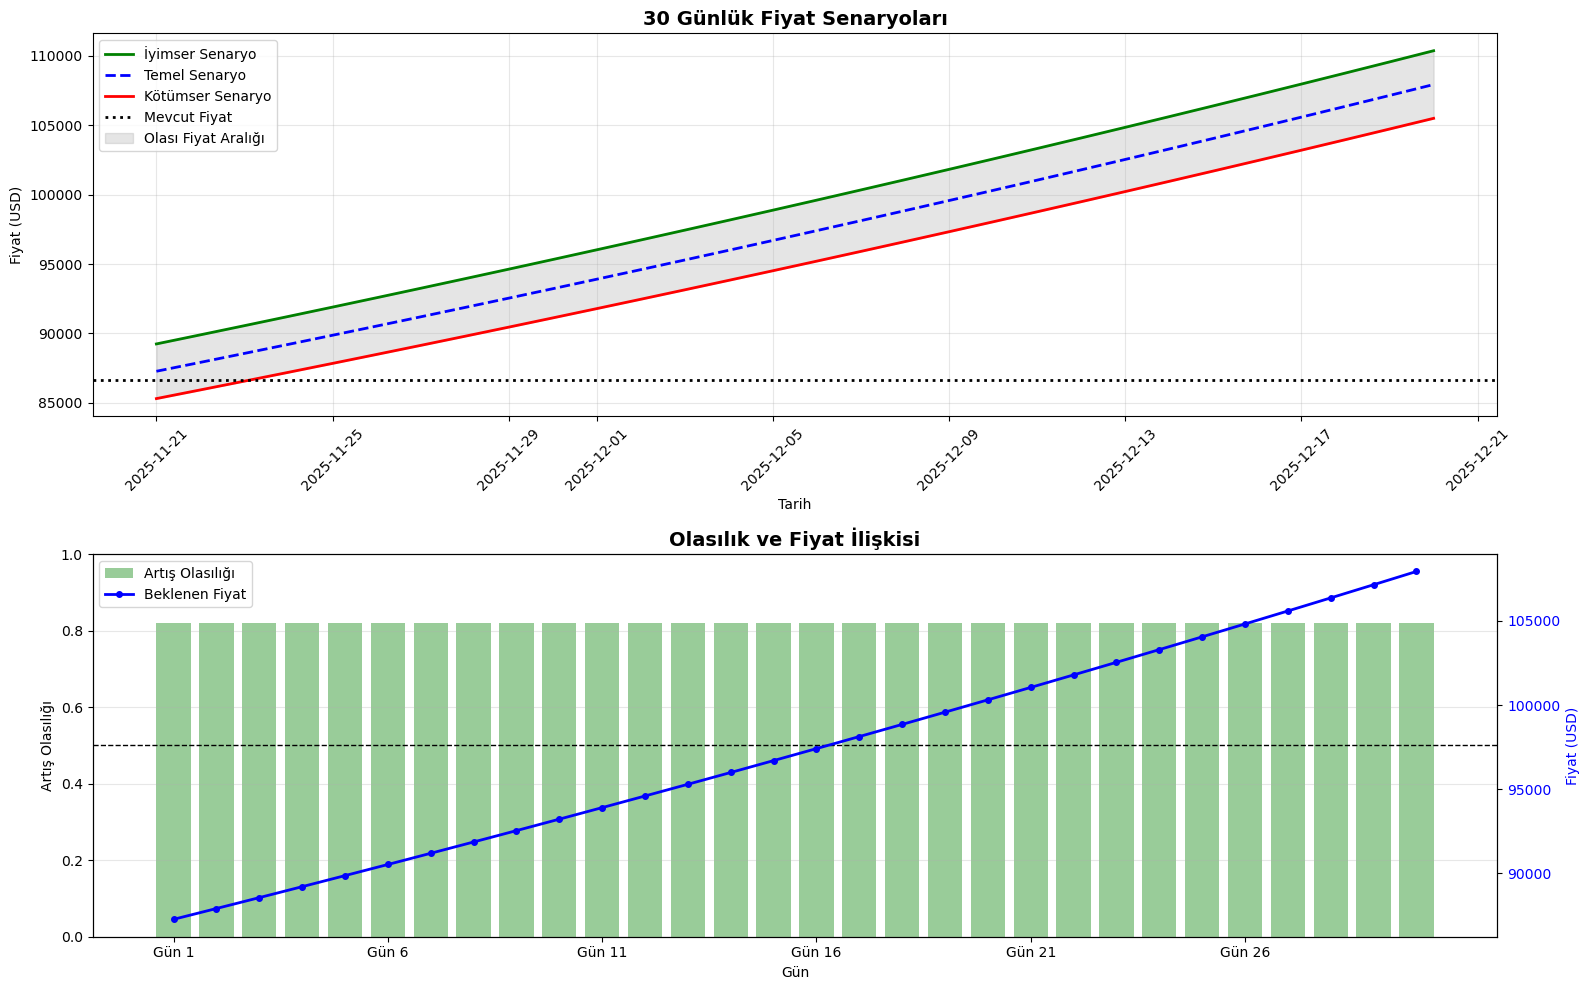

In [19]:
# Senaryo Analizi Görselleştirmesi
try:
    # Gerekli değişkenleri kontrol et
    try:
        current_price
    except NameError:
        current_price = df['Close'].iloc[-1]
    
    try:
        analysis_df
    except NameError:
        print("Hata: analysis_df bulunamadı. Lütfen önce Cell 24 ve 25'i çalıştırın.")
        raise
    
    try:
        future_predictions_detailed
    except NameError:
        print("Hata: future_predictions_detailed bulunamadı. Lütfen önce Cell 24'ü çalıştırın.")
        raise
    
    # future_dates'i oluştur
    future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30, freq='D')
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Senaryo karşılaştırması
    ax1 = axes[0]
    ax1.plot(future_dates, analysis_df['optimistic_price'], label='İyimser Senaryo', 
             linewidth=2, color='green', linestyle='-')
    ax1.plot(future_dates, analysis_df['base_price'], label='Temel Senaryo', 
             linewidth=2, color='blue', linestyle='--')
    ax1.plot(future_dates, analysis_df['pessimistic_price'], label='Kötümser Senaryo', 
             linewidth=2, color='red', linestyle='-')
    ax1.axhline(y=current_price, color='black', linestyle=':', linewidth=2, label='Mevcut Fiyat')
    ax1.fill_between(future_dates, analysis_df['pessimistic_price'], analysis_df['optimistic_price'], 
                     alpha=0.2, color='gray', label='Olası Fiyat Aralığı')
    ax1.set_title('30 Günlük Fiyat Senaryoları', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tarih')
    ax1.set_ylabel('Fiyat (USD)')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Olasılık ve fiyat ilişkisi
    ax2 = axes[1]
    ax2_twin = ax2.twinx()

    # Olasılık çubukları
    colors = ['red' if p == 0 else 'green' for p in future_predictions_detailed]
    bars = ax2.bar(range(30), future_probabilities_detailed, color=colors, alpha=0.4, label='Artış Olasılığı')
    ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Gün')
    ax2.set_ylabel('Artış Olasılığı', color='black')
    ax2.set_ylim([0, 1])
    ax2.set_xticks(range(0, 30, 5))
    ax2.set_xticklabels([f'Gün {i}' for i in range(1, 31, 5)])
    ax2.tick_params(axis='y', labelcolor='black')

    # Fiyat çizgisi
    line = ax2_twin.plot(range(30), analysis_df['base_price'], color='blue', linewidth=2, 
                         marker='o', markersize=4, label='Beklenen Fiyat')
    ax2_twin.set_ylabel('Fiyat (USD)', color='blue')
    ax2_twin.tick_params(axis='y', labelcolor='blue')

    # Legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax2.set_title('Olasılık ve Fiyat İlişkisi', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()
    
except NameError as e:
    print(f"Hata: {e}")
    print("\nLütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:")
    print("1. Cell 24: Detaylı analiz fonksiyonu")
    print("2. Cell 25: Analiz sonuçları")
    print("3. Cell 30: Senaryo görselleştirmesi")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")
    import traceback
    traceback.print_exc()


In [20]:
# Özet Rapor
try:
    # Gerekli değişkenleri kontrol et ve hesapla
    try:
        current_price
    except NameError:
        current_price = df['Close'].iloc[-1]
    
    try:
        analysis_df
    except NameError:
        print("Hata: analysis_df bulunamadı. Lütfen önce Cell 24 ve 25'i çalıştırın.")
        raise
    
    try:
        future_predictions_detailed
        future_probabilities_detailed
    except NameError:
        print("Hata: future_predictions_detailed veya future_probabilities_detailed bulunamadı.")
        raise
    
    # Eksik değişkenleri hesapla
    if 'final_price' not in locals():
        final_price = analysis_df['base_price'].iloc[-1]
    
    if 'total_change' not in locals():
        total_change = ((final_price - current_price) / current_price) * 100
    
    if 'increase_days' not in locals():
        increase_days = sum(future_predictions_detailed)
        decrease_days = 30 - increase_days
    
    if 'avg_probability' not in locals():
        avg_probability = np.mean(future_probabilities_detailed)
    
    # Trend analizi değişkenleri
    try:
        trend_direction
        trend_strength
        max_price
        max_price_day
        min_price
        min_price_day
    except NameError:
        week1_avg = analysis_df[analysis_df['day'] <= 7]['base_price'].mean()
        week4_avg = analysis_df[analysis_df['day'] > 21]['base_price'].mean()
        if week4_avg > week1_avg:
            trend_direction = "Yükseliş"
            trend_strength = ((week4_avg - week1_avg) / week1_avg) * 100
        else:
            trend_direction = "Düşüş"
            trend_strength = ((week1_avg - week4_avg) / week1_avg) * 100
        max_price_day = analysis_df.loc[analysis_df['base_price'].idxmax(), 'day']
        min_price_day = analysis_df.loc[analysis_df['base_price'].idxmin(), 'day']
        max_price = analysis_df['base_price'].max()
        min_price = analysis_df['base_price'].min()
    
    # Risk analizi değişkenleri
    try:
        risk_level
        risk_score
        max_drawdown
        max_gain
        confidence_95_lower
        confidence_95_upper
    except NameError:
        price_volatility = analysis_df['base_price'].std()
        max_drawdown = ((analysis_df['base_price'] - analysis_df['base_price'].cummax()) / analysis_df['base_price'].cummax() * 100).min()
        max_gain = ((analysis_df['base_price'] - analysis_df['base_price'].cummin()) / analysis_df['base_price'].cummin() * 100).max()
        confidence_95_lower = analysis_df['pessimistic_price'].quantile(0.025)
        confidence_95_upper = analysis_df['optimistic_price'].quantile(0.975)
        risk_score = min(100, abs(max_drawdown) * 2 + price_volatility / current_price * 1000)
        if risk_score < 30:
            risk_level = "Düşük"
        elif risk_score < 60:
            risk_level = "Orta"
        else:
            risk_level = "Yüksek"
    
    print("\n" + "=" * 80)
    print("30 GÜNLÜK ANALİZ ÖZET RAPORU")
    print("=" * 80)

    print(f"\n📊 MEVCUT DURUM:")
    print(f"   • Mevcut Fiyat: ${current_price:,.2f}")
    print(f"   • Analiz Tarihi: {datetime.now().strftime('%Y-%m-%d')}")

    print(f"\n📈 TAHMİN ÖZETİ:")
    print(f"   • 30 gün sonra beklenen fiyat: ${final_price:,.2f}")
    print(f"   • Beklenen toplam değişim: {total_change:+.2f}%")
    print(f"   • Artış tahmini: {increase_days} gün ({increase_days/30:.1%})")
    print(f"   • Düşüş tahmini: {decrease_days} gün ({decrease_days/30:.1%})")

    print(f"\n📉 TREND ANALİZİ:")
    print(f"   • Genel Trend: {trend_direction}")
    print(f"   • Trend Gücü: {trend_strength:.2f}%")
    print(f"   • En yüksek beklenen: ${max_price:,.2f} (Gün {int(max_price_day)})")
    print(f"   • En düşük beklenen: ${min_price:,.2f} (Gün {int(min_price_day)})")

    print(f"\n⚠️  RİSK ANALİZİ:")
    print(f"   • Risk Seviyesi: {risk_level}")
    print(f"   • Risk Skoru: {risk_score:.1f}/100")
    print(f"   • Maksimum düşüş: {max_drawdown:.2f}%")
    print(f"   • Maksimum kazanç: {max_gain:.2f}%")
    print(f"   • 95% Güven Aralığı: ${confidence_95_lower:,.2f} - ${confidence_95_upper:,.2f}")

    print(f"\n💡 ÖNERİLER:")
    if risk_score > 60:
        print("   ⚠️  Yüksek risk seviyesi tespit edildi. Dikkatli olunmalı.")
    elif risk_score < 30:
        print("   ✅ Düşük risk seviyesi. Nispeten güvenli görünüyor.")
    else:
        print("   ⚖️  Orta risk seviyesi. Dengeli bir yaklaşım önerilir.")

    if trend_direction == "Yükseliş":
        print(f"   📈 Yükseliş trendi devam ediyor. Trend gücü: {trend_strength:.2f}%")
    else:
        print(f"   📉 Düşüş trendi görülüyor. Trend gücü: {trend_strength:.2f}%")

    if avg_probability > 0.6:
        print(f"   ✅ Yüksek artış olasılığı ({avg_probability:.1%})")
    elif avg_probability < 0.4:
        print(f"   ⚠️  Düşük artış olasılığı ({avg_probability:.1%})")
    else:
        print(f"   ⚖️  Dengeli olasılık dağılımı ({avg_probability:.1%})")

    print("\n" + "=" * 80)
    print("NOT: Bu analiz bir baseline modeline dayanmaktadır.")
    print("Yatırım kararları için profesyonel finansal danışmanlık alınmalıdır.")
    print("=" * 80)
    
except NameError as e:
    print(f"Hata: {e}")
    print("\nLütfen şu hücreleri sırayla çalıştırdığınızdan emin olun:")
    print("1. Cell 24: Detaylı analiz fonksiyonu")
    print("2. Cell 25: Analiz sonuçları")
    print("3. Cell 26: Risk analizi")
    print("4. Cell 27: Trend analizi")
    print("5. Cell 31: Özet rapor")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")
    import traceback
    traceback.print_exc()



30 GÜNLÜK ANALİZ ÖZET RAPORU

📊 MEVCUT DURUM:
   • Mevcut Fiyat: $86,631.90
   • Analiz Tarihi: 2025-11-21

📈 TAHMİN ÖZETİ:
   • 30 gün sonra beklenen fiyat: $107,937.01
   • Beklenen toplam değişim: +24.59%
   • Artış tahmini: 30 gün (100.0%)
   • Düşüş tahmini: 0 gün (0.0%)

📉 TREND ANALİZİ:
   • Genel Trend: Yükseliş
   • Trend Gücü: 17.51%
   • En yüksek beklenen: $107,937.01 (Gün 30)
   • En düşük beklenen: $87,269.18 (Gün 1)

⚠️  RİSK ANALİZİ:
   • Risk Seviyesi: Yüksek
   • Risk Skoru: 72.4/100
   • Maksimum düşüş: 0.00%
   • Maksimum kazanç: 23.68%
   • 95% Güven Aralığı: $85,754.02 - $109,789.32

💡 ÖNERİLER:
   ⚠️  Yüksek risk seviyesi tespit edildi. Dikkatli olunmalı.
   📈 Yükseliş trendi devam ediyor. Trend gücü: 17.51%
   ✅ Yüksek artış olasılığı (82.0%)

NOT: Bu analiz bir baseline modeline dayanmaktadır.
Yatırım kararları için profesyonel finansal danışmanlık alınmalıdır.
